# <a id='toc1_'></a>[Recommender System Design Based on Customer's Online Shopping Behavior](#toc0_)

Group Member: 李辰曦 龚彦同 夏江林 王前

**Table of contents**<a id='toc0_'></a>    
- [Recommender System Design Based on Customer's Online Shopping Behavior](#toc1_)    
  - [Data Preprocession and Exploration](#toc1_1_)    
    - [User and Real Sessions](#toc1_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Data Preprocession and Exploration](#toc0_)

In [43]:
import random

import numpy as np
import pandas as pd

from matplotlib import dates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Because our train data are large (about 10 GB), it is hard to read the json file by pandas directly (out of memory). Therefore, we devided these data in chunks, then we merge the chunks.

In [44]:
%%time
chunks =pd.read_json('../data_json/train.jsonl', lines=True, chunksize=100_000)

train = pd.DataFrame()

for i, chunk in enumerate(chunks):
    event_dict = {
        'session': [],
        'aid': [],
        'ts': [],
        'type': []
    }

    if i >= 2:
        break
    for session, events in zip(chunk['session'].tolist(), \
                               chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    chunk_session = pd.DataFrame(event_dict)
    train = pd.concat([train, chunk_session])

CPU times: user 19.2 s, sys: 7.71 s, total: 26.9 s
Wall time: 29.2 s


In [45]:
train = train.reset_index(drop=True)
display(train)

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


### <a id='toc1_1_1_'></a>[User and Real Sessions](#toc0_)

In this section, we display users and their real session by showing the temporal characteristics of the data. We observe that users exhibt regular patterns of session behavior. These observations can help us characterize and engineer features for users. These observations can also give us insight into predicting future `click`, `cart` and `order` behavior.

In [46]:
# copy the train dataframe for time-series analysis
df_series = train.copy(deep=True)
display(df_series)

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


First, it is necessary to process a portion of the data in order to facilitate the presentation of time series features.

The column `ts` means timestamp, we need to transfer timestamp to the type like `YYYY-MM-DD hh:mm:ss`. To facilitate analysis, we alse need to encode the column `type`. Then we compute the day and hour of users' activities, and filter the users who each have over 40 item interactions.

In [47]:
# timestamp transfer
df_series.ts = pd.to_datetime(df_series.ts * 1e6)

# encode propety type
type_to_num = {'clicks': 0,
               'carts': 1,
               'orders': 2}
df_series['type'] = df_series['type'].map(type_to_num)
display(df_series)


,session,aid,ts,type
0,0,1517085,2022-07-31 22:00:00.024999936,0
1,0,1563459,2022-07-31 22:01:44.511000064,0
2,0,1309446,2022-08-01 15:23:59.425999872,0
3,0,16246,2022-08-01 15:28:39.996999936,0
4,0,1781822,2022-08-01 15:31:11.344000000,0
...,...,...,...,...
10285556,199999,928064,2022-08-01 06:46:48.967000064,0
10285557,199999,849970,2022-08-01 06:47:29.078000128,0
10285558,199999,1052480,2022-08-01 06:49:07.035000064,0
10285559,199999,487255,2022-08-01 06:49:21.116000000,0


In [48]:
df_series = df_series.loc[df_series.ts >= pd.to_datetime('2022-08-01')]

In [49]:
# Compute day and hour of activities
df_series['day'] = df_series.ts.dt.day
df_series['hour'] = df_series.ts.dt.hour
df_series = df_series.reset_index(drop=True)

tmp = df_series.groupby('session').aid.agg('count').rename('n')
df_series = df_series.merge(tmp, on='session')
frequent_users = df_series.loc[df_series.n > 40, 'session'].unique()
print(f'There are {len(frequent_users)} users who each have over 40 item interactions')

There are 65650 users who each have over 40 item interactions


We find real sessions by finding gaps of 2 hours or more between activity. Then we label these gaps as `1` and everything else as `0`. Lastly we perform a groupby `cumsum` to locate sessions.

In [50]:
# compute user real session
df_series.ts = df_series.ts.astype('int64')/1e9
# replicate groupby diff
df_series = df_series.sort_values(['session', 'ts']).reset_index(drop=True)
df_series['d'] = df_series.ts.diff()
df_series.loc[df_series.session.diff()!=0, 'd'] = 0
# Identity real user sessions when we see 2 hour pause in activity
df_series.d = (df_series.d > 60*60*2).astype('int8').fillna(0)
df_series['d'] = df_series.groupby('session').d.cumsum()

The mean session count per train user is 9.9 with right skewed distribution below


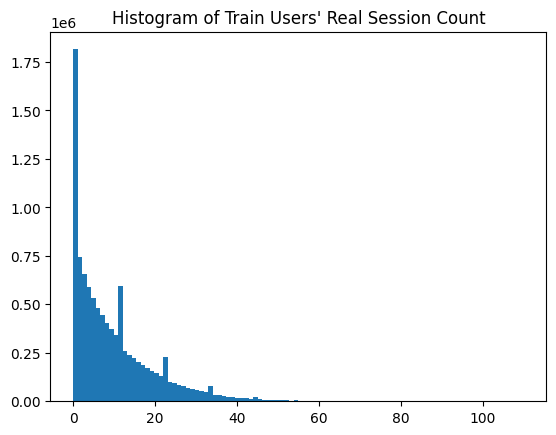

In [51]:
plt.hist(df_series.d, bins=100)
plt.title("Histogram of Train Users' Real Session Count")
m = df_series.d.mean()
print(f'The mean session count per train user is {m:0.1f} with right skewed distribution below')
plt.show()

Below we display a scatter plot with jitter. The x axis is day of the month August 2022. And the y axis is hour of the day. Many dots would fall on top of each other, so we add random x and y jitter. Also we color the `clicks` blue, `carts` orange, and `orders` red. We plot the `clicks` first, then `carts`, then `orders`. This guarentees that the `orders` and `carts` (when present) will always be visible and not be obscured by `click` dots.

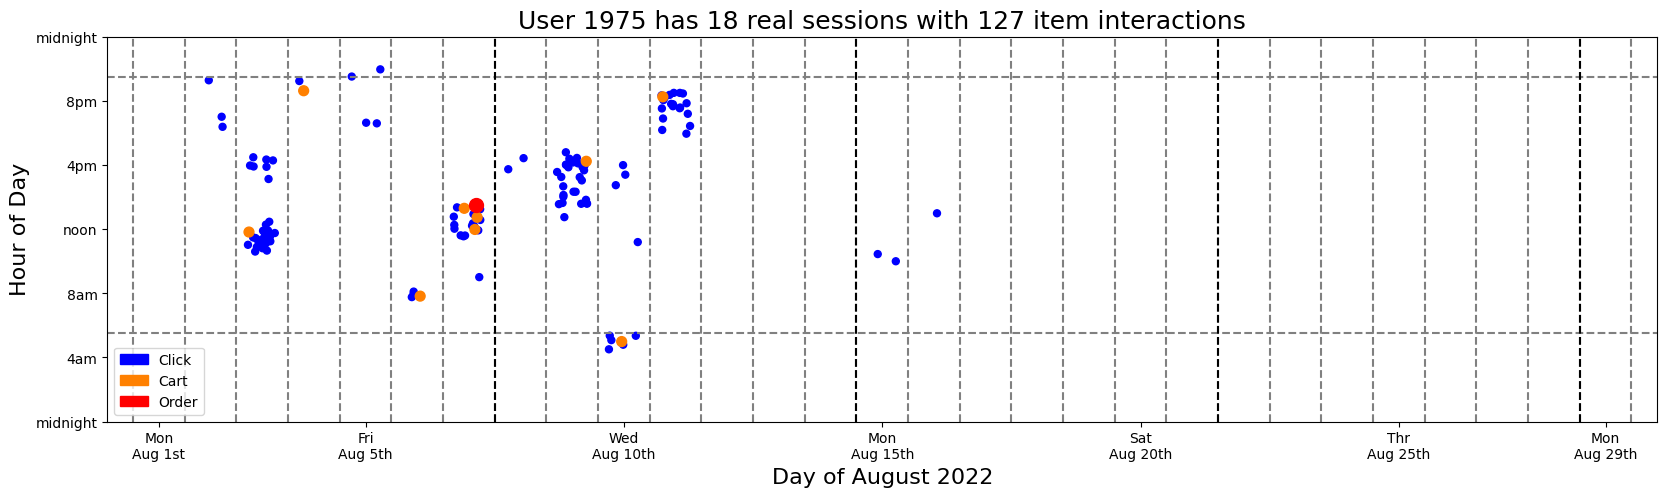

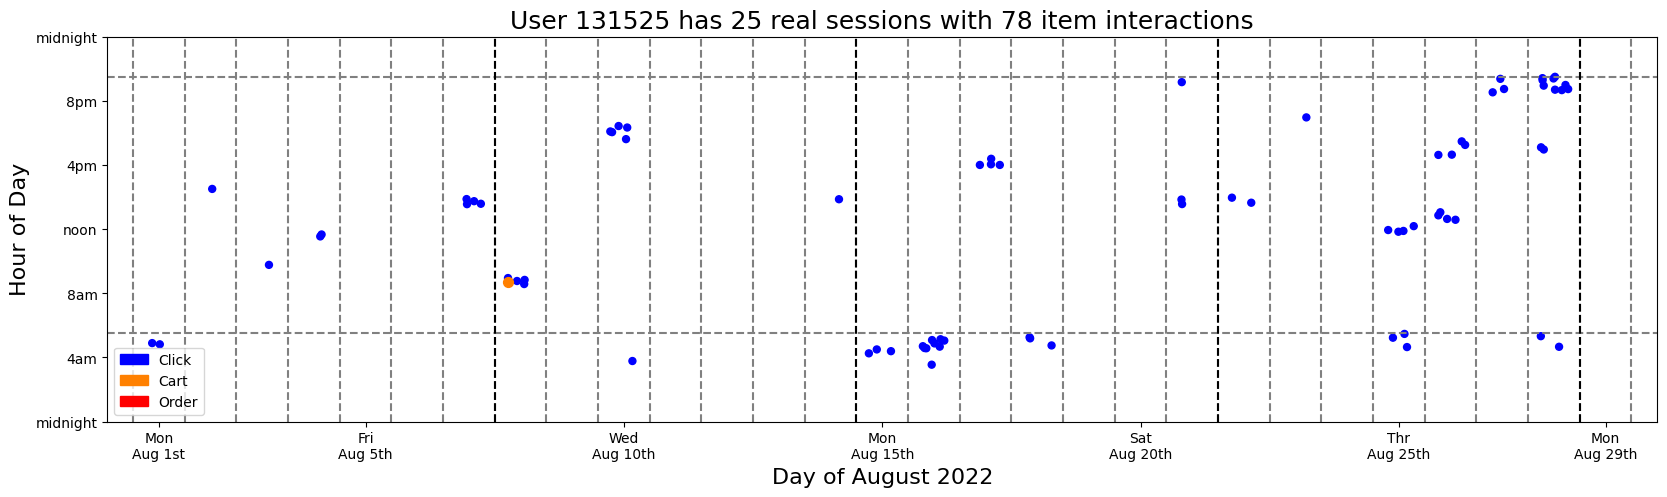

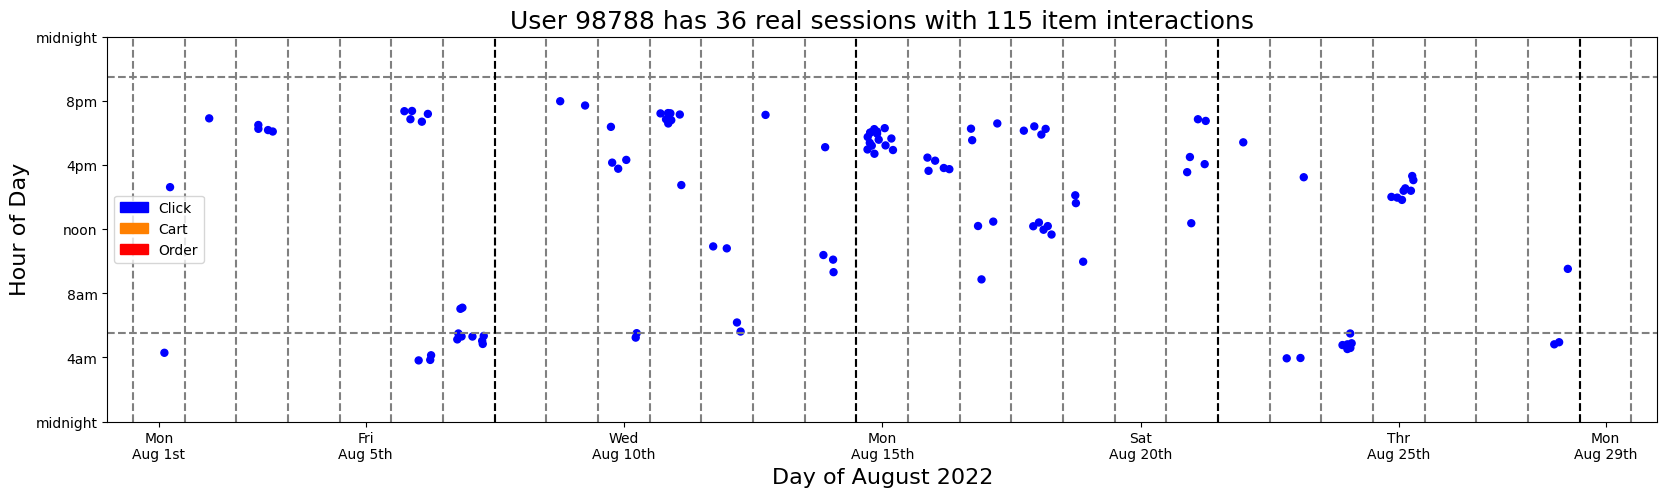

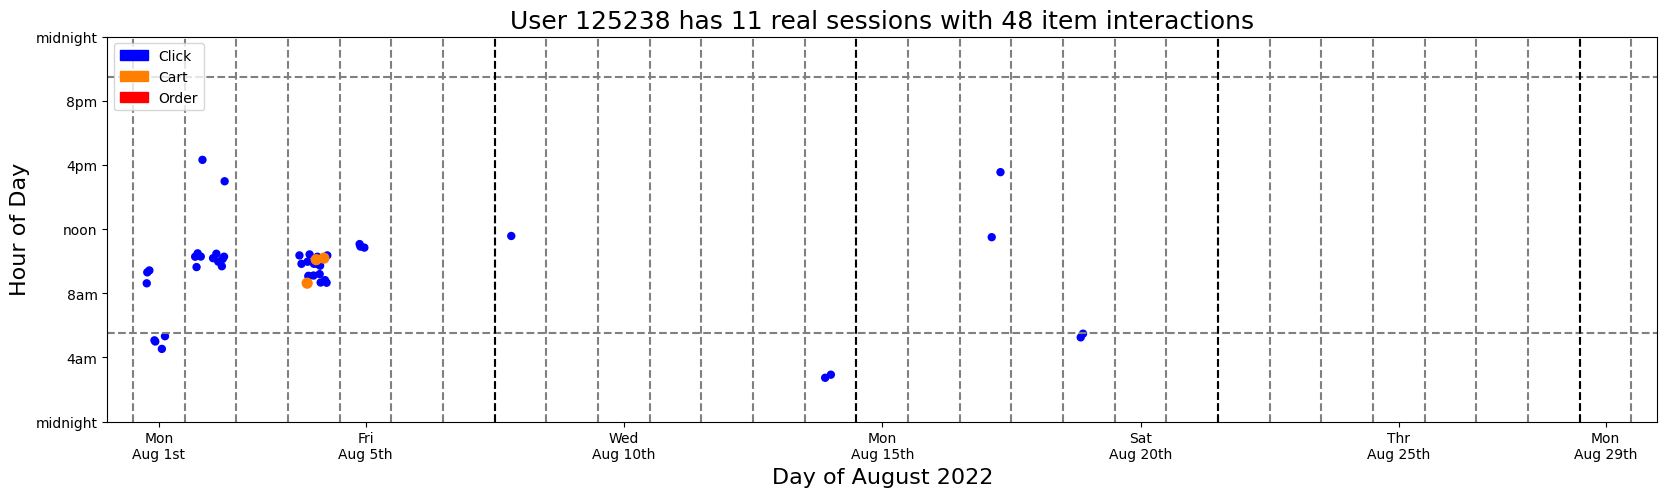

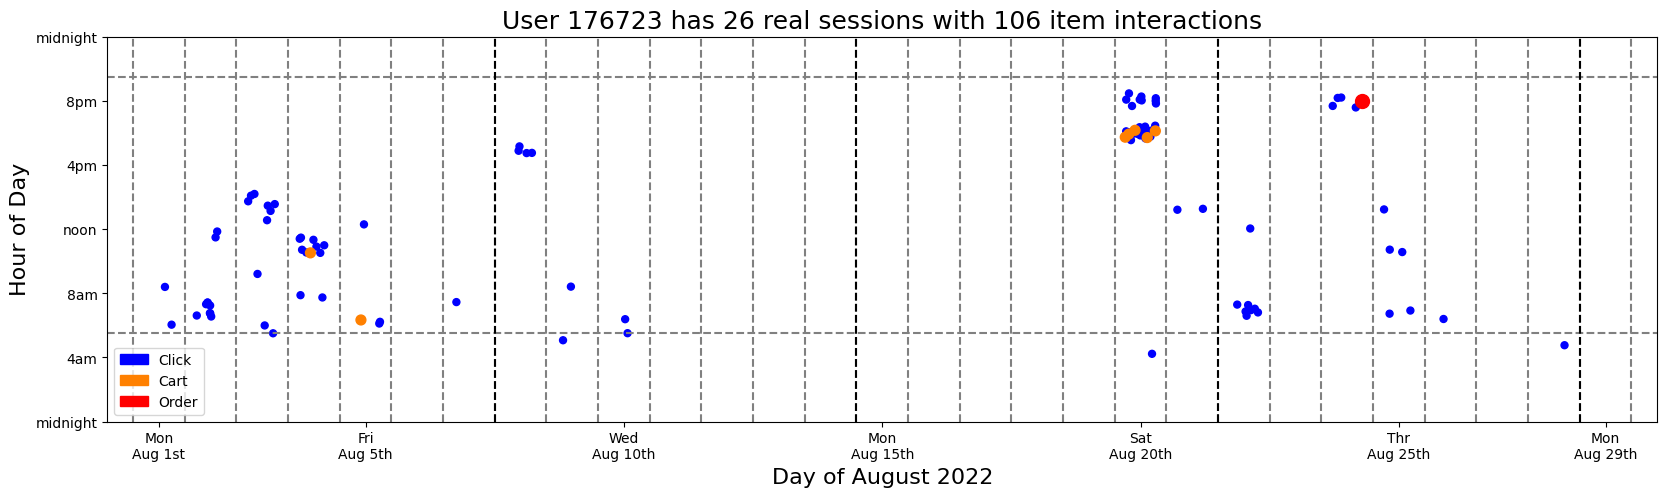

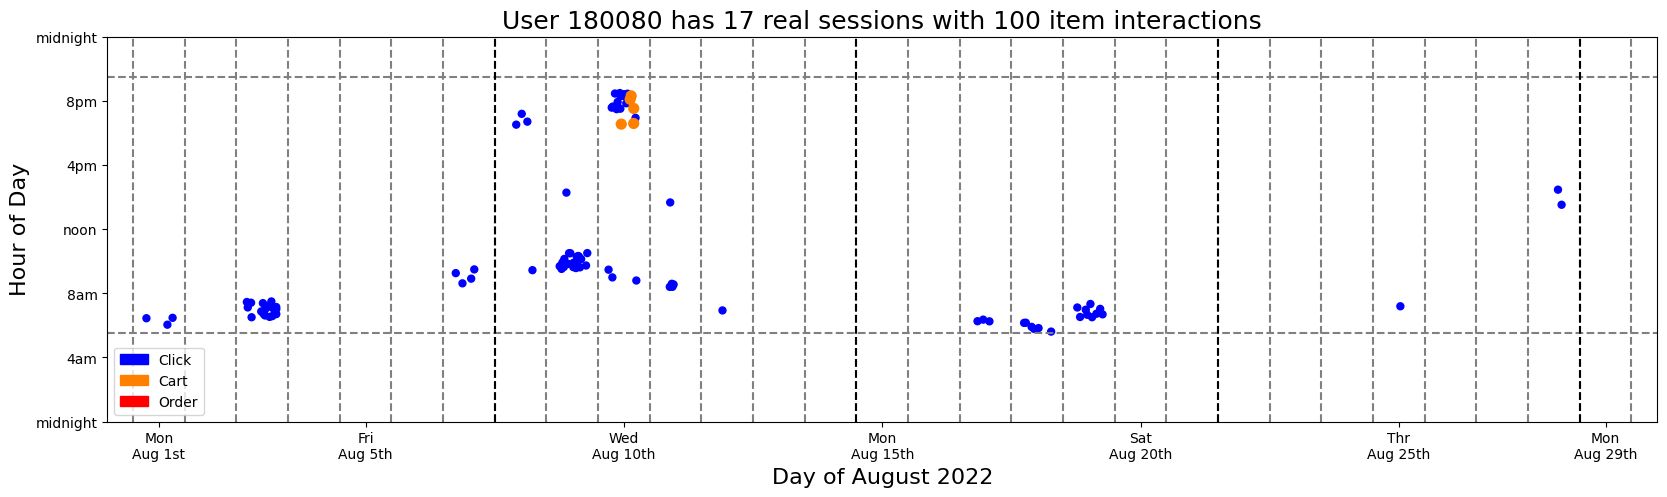

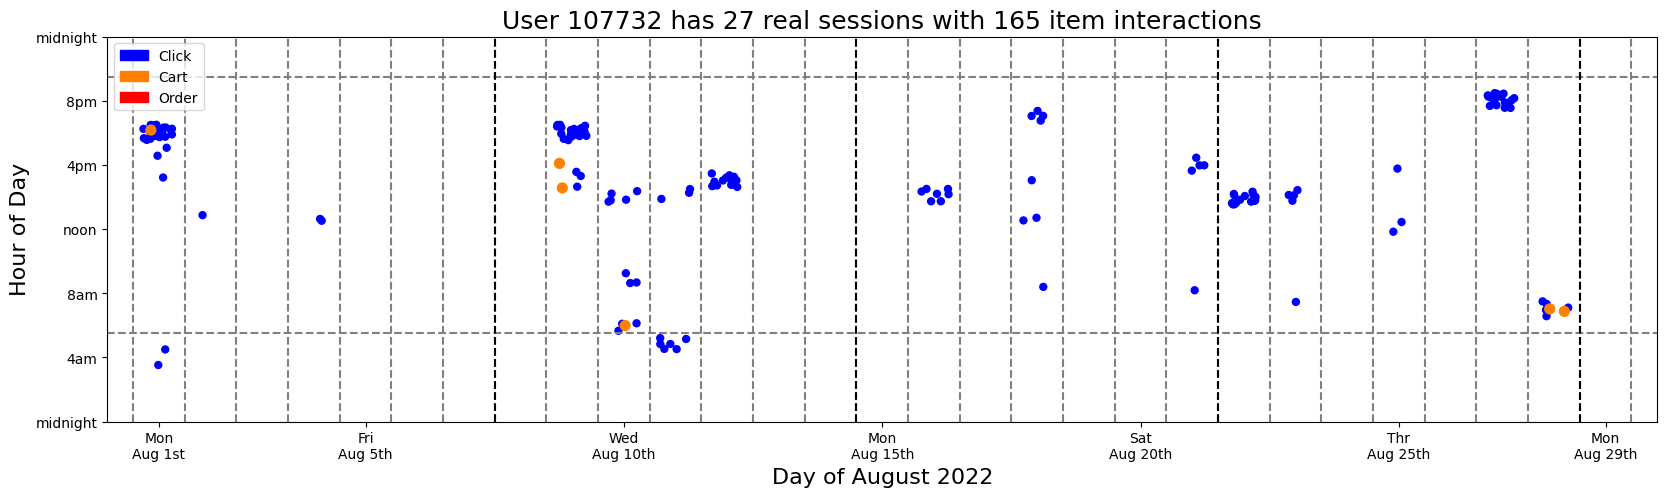

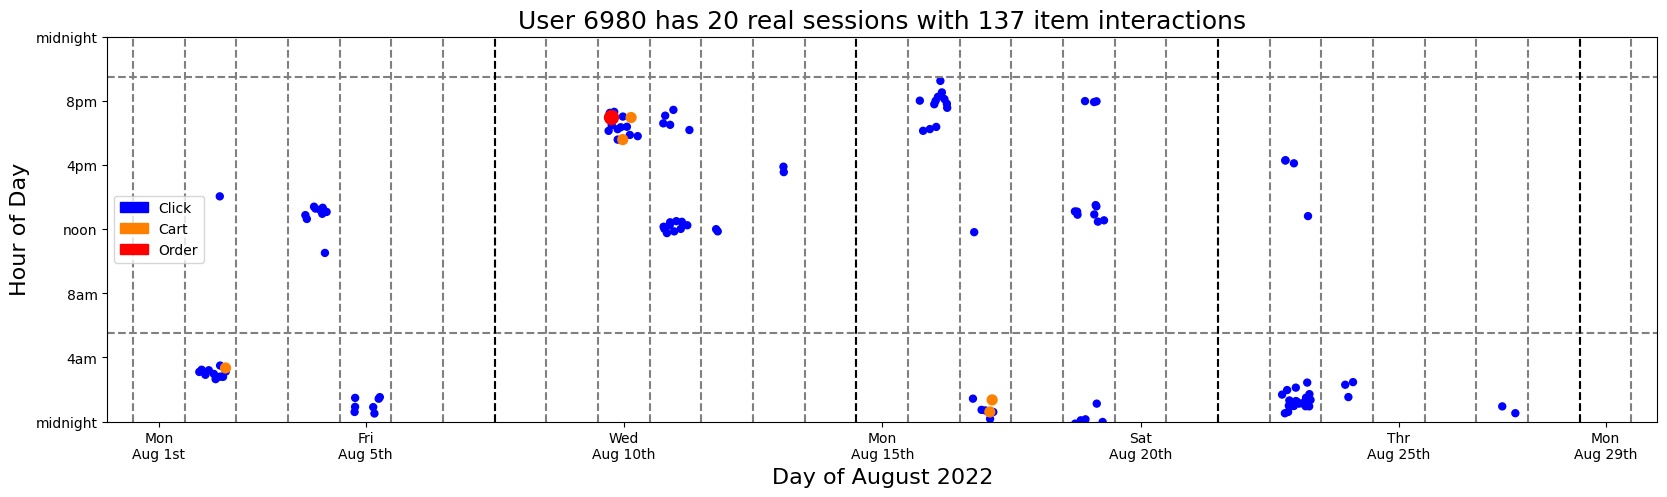

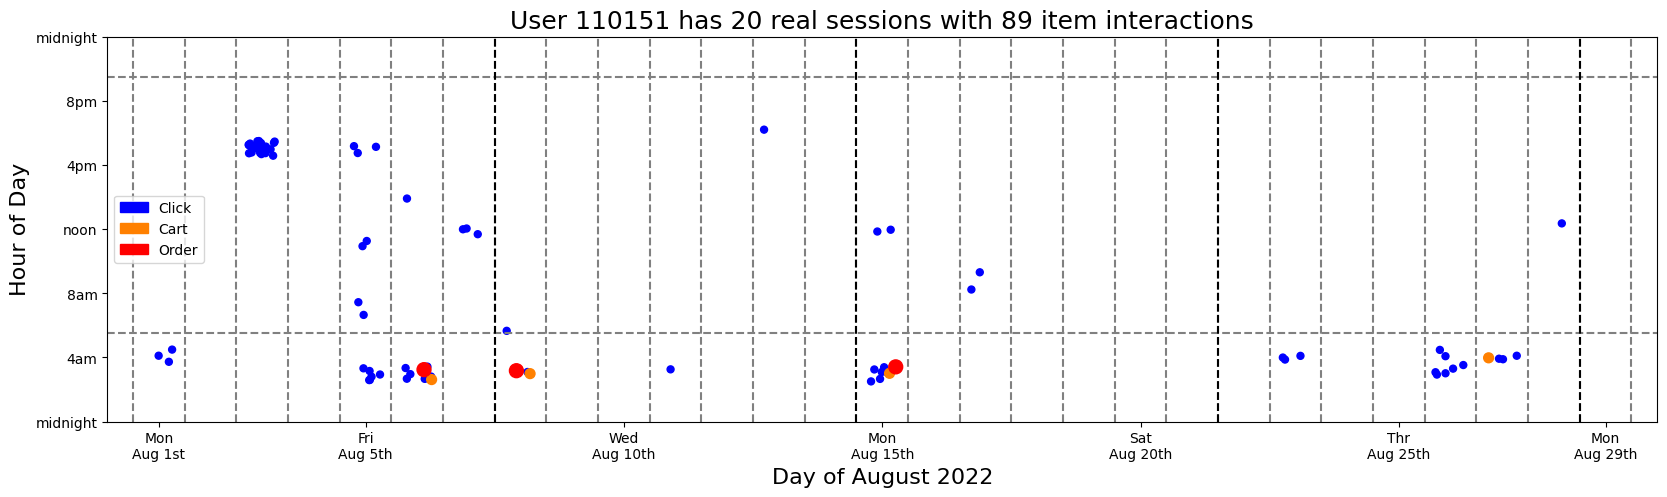

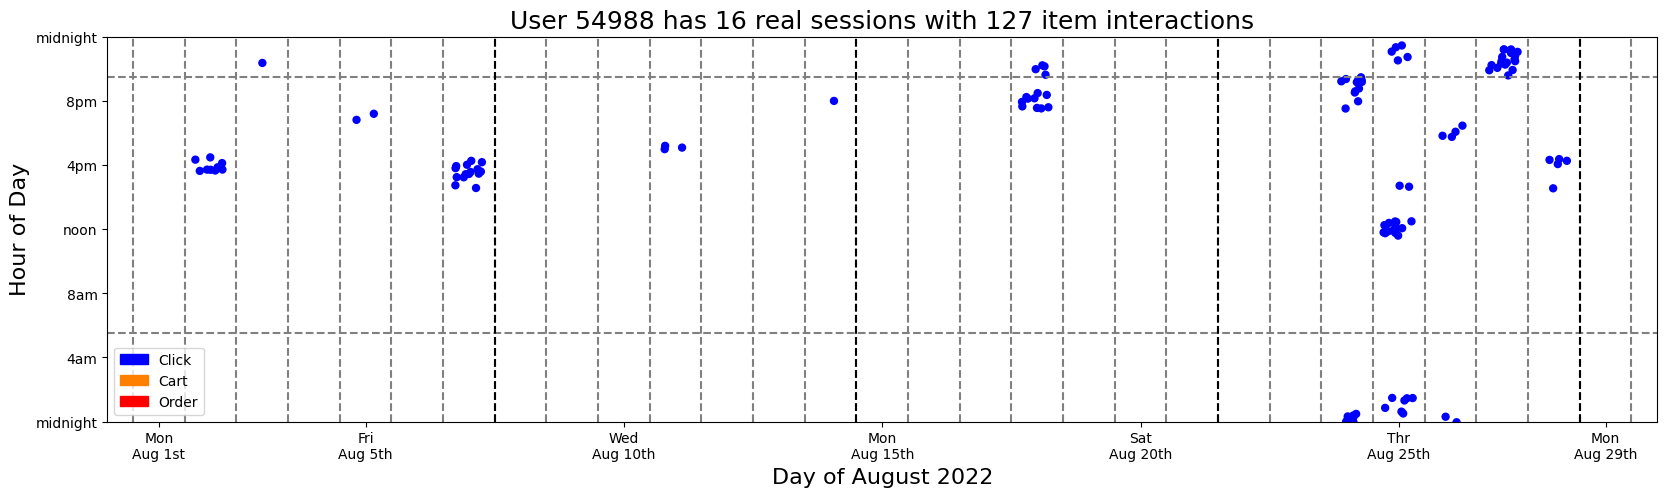

In [52]:
colors = np.array( [(0,0,1),(1,0.5,0),(1,0,0)] )

for k in range(10):
    u = np.random.choice(frequent_users)
    tmp = df_series.loc[df_series.session==u]

    ss = tmp.d.max()+1
    ii = len(tmp)
    
    plt.figure(figsize=(20,5))
    for j in [0,1,2]:
        s = 25
        if j==1: s=50
        elif j==2: s=100
        tmp2 = tmp.loc[tmp['type']==j]
        xx = np.random.uniform(-0.3,0.3,len(tmp2))
        yy = np.random.uniform(-0.5,0.5,len(tmp2))
        plt.scatter(tmp2.day.values+xx, tmp2.hour.values+yy, s=s, c=colors[tmp2['type'].values])
    plt.ylim((0,24))
    plt.xlim((0,30))
    c1 = mpatches.Patch(color=colors[0], label='Click')
    c2 = mpatches.Patch(color=colors[1], label='Cart')
    c3 = mpatches.Patch(color=colors[2], label='Order')
    plt.plot([0,30],[6-0.5,6-0.5],'--',color='gray')
    plt.plot([0,30],[21+0.5,21+0.5],'--',color='gray')
    for k in range(0,30):
        plt.plot([k+0.5,k+0.5],[0,24],'--',color='gray')
    for k in range(1,5):
        plt.plot([7*k+0.5,7*k+0.5],[0,24],'--',color='black')
    plt.legend(handles=[c1,c2,c3])
    plt.xlabel('Day of August 2022',size=16)
    plt.xticks([1,5,10,15,20,25,29],['Mon\nAug 1st','Fri\nAug 5th','Wed\nAug 10th','Mon\nAug 15th','Sat\nAug 20th','Thr\nAug 25th','Mon\nAug 29th'])
    plt.ylabel('Hour of Day',size=16)
    plt.yticks([0,4,8,12,16,20,24],['midnight','4am','8am','noon','4pm','8pm','midnight'])
    plt.title(f'User {u} has {ss} real sessions with {ii} item interactions',size=18)
    plt.show()
    print('\n\n')